In [65]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Project 1


What was the point?

- More than just group and join
- We asked real questions about a real dataset from gapminder
- It has the visualizations you built

[Child mortality vs. babies per woman](http://www.gapminder.org/tools/#_locale_id=en;&state_time_value=1960;&marker_axis/_x_which=children/_per/_woman/_total/_fertility&domainMin:null&domainMax:null&zoomedMin:0.84&zoomedMax:9.22&scaleType=linear;&axis/_y_which=child/_mortality/_0/_5/_year/_olds/_dying/_per/_1000/_born&domainMin:null&domainMax:null&zoomedMin:1.9&zoomedMax:756.3&scaleType=log;&size_which=total/_population/_with/_projections&domainMin:null&domainMax:null;;;&chart-type=bubbles)

- Why? Maybe helping children live will increase overpopulation
- But data show population growth is slowing
- Often the only way to make good decisions/policies is to look at data

[Life expectancy vs income per capita](http://www.gapminder.org/tools/#_locale_id=en;&state_time_value=1960;&marker_axis/_x_domainMin:null&domainMax:null&zoomedMin:null&zoomedMax:null;&axis/_y_domainMin:null&domainMax:null&zoomedMin:null&zoomedMax:null;&size_which=total/_population/_with/_projections&domainMin:null&domainMax:null;;;&chart-type=bubbles)

- Lots of countries first increased life expectancy with basic health services, then got richer

5-10 mins

## Swain v Alabama

10-15 mins

Only go over high-level details for now, will dive into more details later.

What is the probability of getting the actual panel with 8/100 black jurors?

1. Start with the distributions of eligible jurors and the actual panel.
2. Draw panels at random from the eligible jurors.
3. See if my actual panel is likely.

### Step 1: Distributions of population and sample

In [3]:
swain = Table().with_columns(
    'Ethnicity', make_array('Black', 'Other'),
    'Eligible', make_array(0.26, 0.74),
    'Panel', make_array(0.08, 0.92)
)

swain.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panel
Black,26%,8%
Other,74%,92%


### Step 2: Draw panels at random from population

In [7]:
population_distribution = swain.column('Eligible')
panel_size = 100

def random_jury_panel():
    panel = swain.select(0).sample(panel_size, weights=swain.column('Eligible'))
    counts = panel.group(0)
    sample_proportions = counts.select(0).with_column('Random', counts.column(1) / panel_size)
    sample_proportions.set_format(1, PercentFormatter(0))
    return swain.join('Ethnicity', sample_proportions)

random_jury_panel()

Ethnicity,Eligible,Panel,Random
Black,26%,8%,30%
Other,74%,92%,70%


### Step 3: See if sample panel is unlikely

In [4]:
def total_variation_distance(distribution_1, distribution_2):
    """Each distribution is an array of proportions that sums to 1."""
    return np.abs(distribution_1 - distribution_2).sum()/2

def table_tvd(table, label_1, label_2):
    return total_variation_distance(table.column(label_1), table.column(label_2))

table_tvd(swain, 'Eligible', 'Panel')

0.18000000000000002

In [8]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(1000): # Repetitions
    new_sample = random_jury_panel()
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random'))

results = Table().with_column('TVD between the population & a random sample', tvds)
results

TVD between the population & a random sample
0.01
0.03
0.05
0.02
0
0.04
0.02
0.04
0.08
0.02


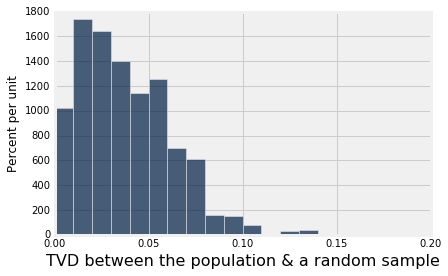

In [9]:
results.hist(bins=np.arange(0, 0.2, 0.01))

In [10]:
table_tvd(swain, 'Eligible', 'Panel')

0.18000000000000002

## Alameda County Juries

15-40 mins

- That was in the 1960s. What about now?
- ACLU released report on Racial and Ethnic Disparities in Alameda County
- Compares population of eligible jurors
- Interviewed panels of 11 different felony trials in 2009 and 2010

### Step 1: Distributions of population and sample

In [11]:
# Data from an ACLU 2010 report
# Racial and Ethnic Disparities in Alameda County Jury Pools
# https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf

panels = Table().with_columns(
    'Ethnicity', make_array('Asian', 'Black', 'Latino', 'White', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.12, 0.54, 0.01),
    'Panels', make_array(0.26, 0.08, 0.08, 0.54, 0.04)
)

panels.set_format([1, 2], PercentFormatter(0))

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


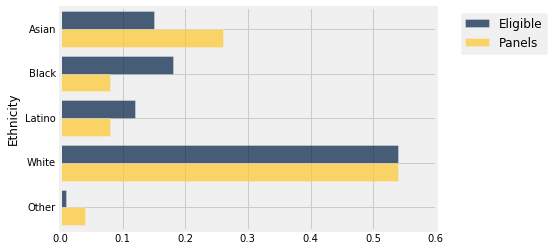

In [12]:
panels.barh(0)

### Step 2: Draw panels at random from population

In [19]:
panels.select('Ethnicity')

Ethnicity
Asian
Black
Latino
White
Other


In [23]:
panels.select('Ethnicity').sample(10000).group(0)

Ethnicity,count
Asian,2024
Black,1930
Latino,2008
Other,2117
White,1921


In [20]:
panels.column('Eligible')

array([ 0.15,  0.18,  0.12,  0.54,  0.01])

In [34]:
panels.select('Ethnicity').sample(10000, weights=panels.column('Eligible')).group(0)

Ethnicity,count
Asian,1479
Black,1827
Latino,1263
Other,106
White,5325


Buuuuut there's an easier way:

In [38]:
sample = proportions_from_distribution(panels, 'Eligible', 1453)
sample

Ethnicity,Eligible,Panels,Random Sample
Asian,15%,26%,0.148658
Black,18%,8%,0.18307
Latino,12%,8%,0.114246
White,54%,54%,0.543014
Other,1%,4%,0.0110117


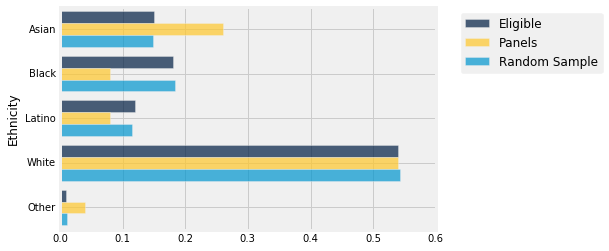

In [39]:
sample.barh('Ethnicity')

### Step back to slide on Empirical Distributions

### Step 3: See if sample panel is unlikely

In [15]:
np.abs(panels.column(1) - panels.column(2)).sum() / 2

0.14000000000000001

In [46]:
def total_variation_distance(distribution_1, distribution_2):
    """Each distribution is an array of proportions that sums to 1."""
    return np.abs(distribution_1 - distribution_2).sum()/2

def table_tvd(table, label_1, label_2):
    return total_variation_distance(table.column(label_1), table.column(label_2))

table_tvd(panels, 'Eligible', 'Panels')

0.14000000000000001

**Repeated trials**

In [60]:
# Compute the empirical distribution of TVDs

tvds = make_array()

for i in np.arange(1000): # Repetitions
    new_sample = proportions_from_distribution(panels, 'Eligible', 1453,)
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random Sample'))

results = Table().with_column('TVD between the population & a random sample', tvds)
results

TVD between the population & a random sample
0.0140606
0.0138747
0.0237371
0.0178252
0.012278
0.0285547
0.0140262
0.0390158
0.0124914
0.00347557


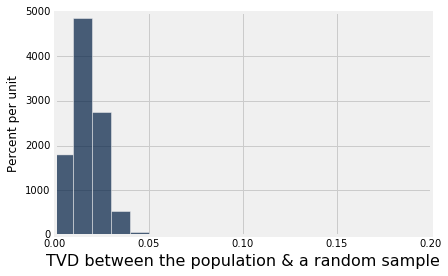

In [61]:
results.hist(bins=np.arange(0, 0.2, 0.01))

In [73]:
def hist_n_samples(tbl, n, bins=None):
    '''Draws histogram of first n rows of first column in tbl.'''
    tbl.take(np.arange(n)).hist(bins=bins)
    plt.ylim(0, 50)
    plt.show()

In [75]:
_ = interact(hist_n_samples, tbl=fixed(results), n=(1, 1000, 10), bins=fixed(np.arange(0, 0.2, 0.01)))

/Users/sam/anaconda3/lib/python3.5/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


Original panel TVD:

In [47]:
table_tvd(panels, 'Eligible', 'Panels')

0.14000000000000001

## How do you think our analysis would change if the jury panels had only 50 people?

In [56]:
sample_50 = proportions_from_distribution(panels, 'Eligible', 50)
sample_50.set_format([1, 2, 3], PercentFormatter(0))

Ethnicity,Eligible,Panels,Random Sample
Asian,15%,26%,12%
Black,18%,8%,22%
Latino,12%,8%,8%
White,54%,54%,58%
Other,1%,4%,0%


In [69]:
tvds = make_array()

for i in np.arange(1000): # Repetitions
    new_sample = proportions_from_distribution(panels, 'Eligible', 50)
    tvds = np.append(tvds, table_tvd(new_sample, 'Eligible', 'Random Sample'))

results_50 = Table().with_column('TVD between the population & a random sample', tvds)
results_50

TVD between the population & a random sample
0.05
0.08
0.09
0.09
0.11
0.12
0.1
0.11
0.1
0.18


In [76]:
_ = interact(hist_n_samples, tbl=fixed(results_50), n=(1, 1000, 10), bins=fixed(np.arange(0, 0.2, 0.01)))

/Users/sam/anaconda3/lib/python3.5/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


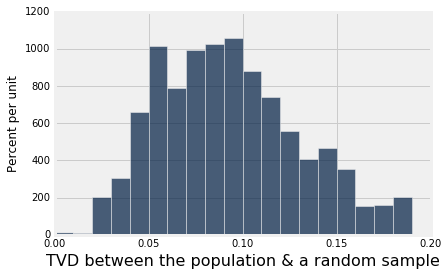

In [62]:
results_50.hist(bins=np.arange(0, 0.2, 0.01))

## Addendum: Alameda County Race & Ethnicity Distribution

In [63]:
# According to the 2010 Census, https://www.census.gov/2010census/popmap/

alameda_race = Table(['Race', 'Population']).with_rows([
    ['White', 649122],
    ['African American', 190451],
    ['Asian', 394560],
    ['AIAN', 9799],
    ['NHPI', 12802],
    ['Some Other Race', 162540],
    ['Two or more Races', 90997],
])

alameda_race.set_format(1, DistributionFormatter).show()

alameda_ethnicity = Table(['Ethnicity', 'Population']).with_rows([
    ['Hispanic or Latino', 339889],
    ['Not Hispanic or Latino', 1170382],
])

alameda_ethnicity.set_format(1, DistributionFormatter).show()

Race,Population
White,42.98%
African American,12.61%
Asian,26.13%
AIAN,0.65%
NHPI,0.85%
Some Other Race,10.76%
Two or more Races,6.03%


Ethnicity,Population
Hispanic or Latino,22.51%
Not Hispanic or Latino,77.49%


In [64]:
panels

Ethnicity,Eligible,Panels
Asian,15%,26%
Black,18%,8%
Latino,12%,8%
White,54%,54%
Other,1%,4%


All analysis is only as good as the data you start with.

## Hypothesis Testing

40-45 mins

High level steps, will refine in lectures this week.

## P-Value

In [ ]:
results.where(0, are.above_or_equal_to(observed)).num_rows / results.num_rows